In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import torch.distributions as dist
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Multinomial

Step 1: generate data and ground-truth parameters

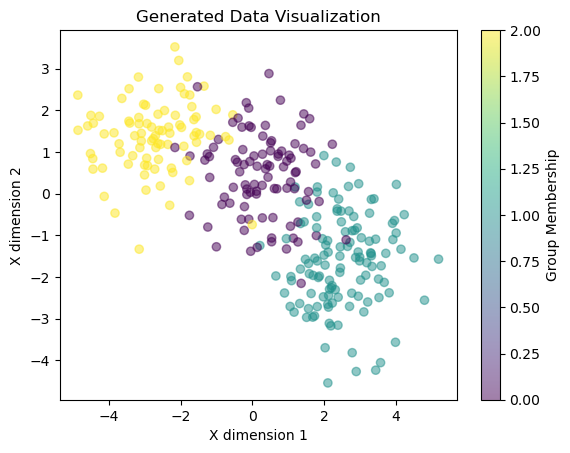

In [17]:
np.random.seed(0)
def generate_data(num_samples, pi, ground_truth_mu_list, sigma, sigma_0, K):
    """
    Generate dataset based on the specified model.

    :param num_samples: Number of samples to generate.
    :param pi: Vector of size K with the probabilities for the multinomial distribution.
    :param ground_truth_mu_list: ground-truth means for each group 
    :param sigma: Standard deviation for the normal distribution of observed data.
    :param sigma_0: Standard deviation for the prior normal distribution of each group.
    :param K: Number of groups.
    :return: Generated dataset.
    """
    # Generate group memberships Z_i
    Z = np.random.choice(K, size=num_samples, p=pi)
    # Generate observed data X_i
    X = np.array([np.random.multivariate_normal(ground_truth_mu_list[Z[i]], np.diag([sigma**2, sigma**2])) for i in range(num_samples)])
    return X, Z

# Example usage
num_samples = 300
K = 3  # Number of groups
input_dim = 2  # Dimension of the observed data
pi = [0.3, 0.4, 0.3]  # Probabilities for each group
# params for the prior distribution of \pi
alpha = torch.ones(K)  # Dirichlet prior for pi
nu_k = np.array([[0,0], [3, -3], [-3,3]])  # Prior means for each group (for each dimension)
# params for the prior distribution of mu_k, in this case is not \nu_k anymore
sigma_0 = 10  # Standard deviation for group means
sigma = 1  # Standard deviation for observed data
mu_0=torch.zeros((K, input_dim))  # Prior mean for the group means
nu_k = np.array(nu_k)
ground_truth_mu_list = [(0.5,0.5), (2.5,-1.5), (-2.5,1.5)]
sigma = 1  # Standard deviation for observed data
sigma_0 = 1  # Standard deviation for group means

X, Z = generate_data(num_samples, pi, ground_truth_mu_list, sigma, sigma_0, K)

# Visualization
plt.scatter(X[:, 0], X[:, 1], c=Z, cmap='viridis', alpha=0.5)
plt.title('Generated Data Visualization')
plt.xlabel('X dimension 1')
plt.ylabel('X dimension 2')
plt.colorbar(label='Group Membership')
plt.show()

# Variational inference for the Gaussian mixture model-- the second simplest case
- We assume that the observed data X_i is generated from a Gaussian mixture model with K groups. We assume the following model:
    - P(X_i|Z_i=k, mu_k, sigma^{2}) ~ N(mu_k, sigma^{2})
    - P(sigma) ~ Uniform(0, 10)
    - P(Z_i=k|pi) ~ Multinomial(pi)
    - mu_k are unknown parameters, but we put prior distributions on them:
        - P(mu_k|nu_k, sigma_0^2) ~ N([0,0], sigma_0^{2}), with very high sigma_0 because we don't have any prior knowledge
    - pi ~ Dirichlet(alpha)

In [20]:
import torch
import torch.nn as nn
from torch.distributions import Normal, Dirichlet, kl_divergence, Categorical
import torch.nn.functional as F
class GumbelSoftmaxVI(nn.Module):
    def __init__(self, alpha, prior_nu, sigma, n_components, sigma_0=10, input_dim=2, temp=0.5):
        """
        :param alpha: Alpha parameter for the Dirichlet prior on pi
        :param prior_nu: Prior parameter for the mean of the Gaussian distribution for each group
        :param sigma: known standard deviation for the Gaussian distribution P(X|\mu_k, \sigma^2)
        :param n_components: number of components in the Gaussian mixture model
        :param sigma_0: known standard deviation for the prior distribution of the mean of the Gaussian distribution for each group
        :param input_dim: dimension of the observed data
        :param temp: parameter for the Gumbel-Softmax trick
        """
        super(GumbelSoftmaxVI, self).__init__()
        self.alpha = alpha
        # Variational parameter for q(mu)
        self.mu_q = nn.Parameter(torch.randn(n_components, input_dim))  
        self.prior_nu = prior_nu
        assert self.mu_q.shape == self.prior_nu.shape, "dimension of prior_nu and mu should be the same. It is not right now"
        self.input_dim = input_dim
        self.sigma = sigma
        self.sigma_0 = sigma_0
        self.n_components = n_components
        self.temp = temp
        # Variational parameter for q(pi)
        self.alpha_q = nn.Parameter(torch.rand_like(self.alpha))
        # Variational logits for q(Z)
        self.logits_z = nn.Parameter(torch.randn(n_components))  # in theory, I can also allow each observation to have a separate logits_z, It is not wrong, because I can argue that with meanfield variational inference, I can let each observation have a particular z's distribution. However, the impelmentation does not stop me from having them share the same values of q_Z (which is like a \pi). Therefore, I will set logits_z to be of size (n_components) instead of (batch_size,n_components) beacuse I believe in the identifiability of a model with fewer parameters that needs to be learned.
    
    def forward(self, x):
        print(type(x))
        batch_size = x.size(0)
        # Variational distribution q(pi)
        q_pi = Dirichlet(self.alpha_q)
                
        # Apply Gumbel-Softmax trick to sample Z
        gumbel_softmax_sample = F.gumbel_softmax(self.logits_z.unsqueeze(0).repeat(batch_size, 1), tau=self.temp, hard=True)  # this function turns the values of logits_z into a distribution, and then sample from it. The sampling is done by the Gumbel-Softmax trick. The hard=True means that the sample is one-hot encoded. The sample is used to sample Z_i for each X_i. The sample is of size (batch_size, n_components)
        
        # Expected log likelihood
        # reparameterize the sample to get the sample from the variational distribution q(mu)
        epsilon = MultivariateNormal(torch.zeros(input_dim), scale_tril=torch.eye(input_dim)*self.sigma_0).sample((self.n_components,))  # (n_components, input_dim)
        mu = self.mu_q + epsilon * self.sigma_0  # this is simplification because here the variance matrix is diagonal and all diag entries are similar. Therefore, we can simplify the formula for the reparameterization trick. In reality, if we have any type of \Sigma as the coariance matrix, we will need to find L s.t. \Sigma =L*L^T (google Cholesky decomposition). Then mu = mu_q + L*epsilon (make sure to check the dimensions)
        x_reconstructed = MultivariateNormal(gumbel_softmax_sample @ mu, scale_tril=torch.eye(input_dim)*self.sigma)
        log_likelihood = x_reconstructed.log_prob(x).sum()  # x should have size (batch_size, input_dim)
        
        # Compute KL divergence for pi
        p_pi = Dirichlet(self.alpha)
        kl_pi = kl_divergence(q_pi, p_pi).sum()
        p_mu = MultivariateNormal(self.prior_nu, scale_tril=torch.eye(input_dim)*self.sigma0)
        q_mu = MultivariateNormal(self.mu_q, scale_tril=torch.eye(input_dim)*self.sigma_0)
        kl_mu = kl_divergence(q_mu, p_mu).sum()
        # ELBO
        elbo = log_likelihood - kl_pi - kl_mu
        return -elbo  # Return negative ELBO for minimization

In [22]:
num_steps = 1000
model = GumbelSoftmaxVI(alpha, prior_nu=mu_0, sigma=sigma, n_components=K, sigma_0=10, input_dim=2, temp=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
X = torch.tensor(X, dtype=torch.float32)
for step in range(num_steps):
    optimizer.zero_grad()
    loss = model(X)  # this should call the forward method of the model
    loss.backward()
    optimizer.step()
    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss.item()}")   
print(model.param)

<class 'torch.Tensor'>


AttributeError: 'GumbelSoftmaxVI' object has no attribute 'num_components'

# Variational inference for the Gaussian mixture model-- the simplest case

We assume that the observed data X_i is generated from a Gaussian mixture model with K groups. The group memberships Z_i are latent variables. The model is defined as follows:
    - P(X_i|Z_i=k, mu_k, sigma^2) ~ N(mu_k, sigma^2)
    - P(Z_i=k|pi) ~ Multinomial(pi)
    - mu_k are unknown parameters, but we put prior distributions on them:
        - P(mu_k|nu_k, sigma_0^2) ~ N(nu_k, sigma_0^2)
    - pi is an unknown parameter

For variational inference, we assume the following variational distributions:
    - q(Z_i) ~ Multinomial(piZ)  # for some prior pi, usually starting condition is that equally distributed across K groups
    - q(mu_k) ~ N(mu_loc, mu_scale)
    - The parameters that we will learn are mu_loc, mu_scale, and pi
Once we have optimized these parameters, we would try to infer the group memberships Z_i based on the posterior probabilities of Z_i given X_i, and the group means mu_k based on the posterior distribution of mu_k given X_i.

In [27]:
# Variational parameters (to be optimized)
mu_loc = torch.randn(nu_k.shape, requires_grad=True)
mu_scale = torch.ones(input_dim, requires_grad=False)
log_pi = torch.zeros(K, requires_grad=True)  # Log probabilities for stability
print('log_pi before training', log_pi)
# change some parameters to tensor so that it;s easier to work with
nu_k = torch.tensor(nu_k, dtype=torch.float32)
tensor_X = torch.tensor(X, dtype=torch.float32)
# Define the optimization
optimizer = torch.optim.Adam([mu_loc, mu_scale, log_pi], lr=0.01)
num_steps = 1000

for step in range(num_steps):
    optimizer.zero_grad()

    # ELBO calculation
    # 1. Log likelihood under the model
    mixture_dist = dist.Categorical(logits=log_pi)
    component_dists = MultivariateNormal(mu_loc, scale_tril=torch.diag(mu_scale))
    likelihood = dist.MixtureSameFamily(mixture_dist, component_dists)
    log_likelihood = likelihood.log_prob(tensor_X).sum()

    # 2. KL divergence between variational distribution and prior
    covariance_matrices = torch.diag_embed(torch.full((len(nu_k), input_dim), sigma_0, dtype=torch.float32))
    prior = MultivariateNormal(nu_k, scal   e_tril=covariance_matrices)
    variational_dist = MultivariateNormal(mu_loc, scale_tril=torch.diag(mu_scale))
    kl_divergence = dist.kl_divergence(variational_dist, prior).sum() + dist.kl_divergence(mixture_dist, dist.Categorical(probs=torch.tensor(pi, dtype=float))).sum()

    # 3. Negative ELBO (since we're minimizing)
    elbo = log_likelihood - kl_divergence
    loss = -elbo

    loss.backward()
    optimizer.step()

    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss.item()}")

# Final variational parameters
print("Variational means:", mu_loc)
print("Variational standard deviations:", mu_scale)
print("Variational log pi:", log_pi)
print('Pi:', torch.softmax(log_pi, dim=0))

log_pi before training tensor([0., 0., 0.], requires_grad=True)
Step 0: Loss = 1732.6683524277657
Step 100: Loss = 1294.9177396618811


/var/folders/nw/whgvtnb145zcxp132btdfq0r0000gq/T/ipykernel_74672/4203623343.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  nu_k = torch.tensor(nu_k, dtype=torch.float32)


Step 200: Loss = 1203.1330906340318
Step 300: Loss = 1162.0312396323397
Step 400: Loss = 1155.2327129445605
Step 500: Loss = 1154.5812321471956
Step 600: Loss = 1154.534552117475
Step 700: Loss = 1154.5323463929965
Step 800: Loss = 1154.5323541543175
Step 900: Loss = 1154.5323852498652
Variational means: tensor([[ 0.3780,  0.5194],
        [-2.6135,  1.3047],
        [ 2.4024, -1.6195]], requires_grad=True)
Variational standard deviations: tensor([1., 1.])
Variational log pi: tensor([-0.1831, -0.1784,  0.1517], requires_grad=True)
Pi: tensor([0.2939, 0.2953, 0.4108], grad_fn=<SoftmaxBackward0>)


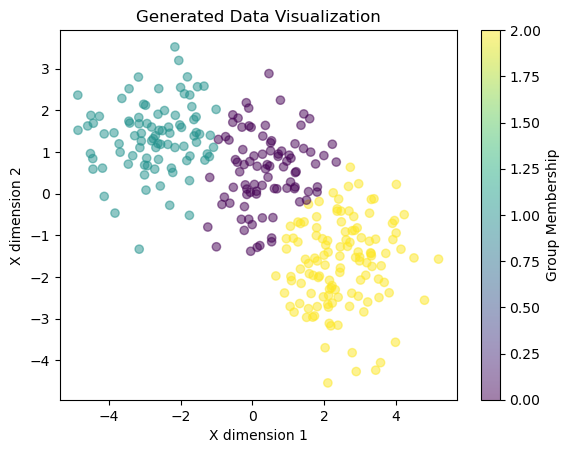

In [30]:
mixture_dist = dist.Categorical(logits=log_pi)  # size #(K)
component_dists = MultivariateNormal(mu_loc, scale_tril=torch.diag(mu_scale))  # size #(K, input_dim)
X_expanded = tensor_X.unsqueeze(1).repeat(1,K,1)  # size #(num_sample, K, input_dim), where each K's X_i is the same
log_prob_components = component_dists.log_prob(X_expanded)  # size #(n_sample, K)
log_prob_components = log_prob_components + mixture_dist.logits  # size #(n_sample, K)
post_Z = log_prob_components.softmax(dim=1)  # size #(n_sample, K)
pred_Z = post_Z.argmax(dim=1)
plt.scatter(X[:, 0], X[:, 1], c=pred_Z, cmap='viridis', alpha=0.5)
plt.title('Generated Data Visualization')
plt.xlabel('X dimension 1')
plt.ylabel('X dimension 2')
plt.colorbar(label='Group Membership')
plt.show()


Step 2: implement the Gibbs sampler for the Gaussian mixture model

In [36]:
num_iters = 500
# K is assumed to be known as specified in the ground-truth parameters
# Initialize the group memberships Z_i
pred_Z = np.random.choice(K, size=num_samples, p=pi)
# Initialize the group means mu_k
pred_mu_k = list(map(lambda nu_k: np.random.multivariate_normal(nu_k, np.diag([sigma_0**2, sigma_0**2])), nu_k))
# for each iteration:
for iter in range(num_iters):
    # for each data point X_i:
    # print('iter', iter)
    for i in range(num_samples):
        # sample Z_i from the posterior distribution
        post_Zi_prob = np.array([pi[k] * multivariate_normal.pdf(X[i], pred_mu_k[k], np.diag([sigma**2, sigma**2])) for k in range(K)])
        # print('X[i]', X[i])
        # print('pred_mu_k', pred_mu_k)
        # print('post_Zi_prob', post_Zi_prob)
        pred_Z[i] = np.random.choice(K, p=post_Zi_prob/np.sum(post_Zi_prob))
    # sample mu_k from the posterior distribution
    pred_mu_k = []
    for k in range(K):
        X_Zk = X[pred_Z == k]  # rows: X_i, columns: X_i's dimensions
        num_X_Zk = len(X_Zk)  # number of X_i's in group k
        sum_X_Zk = np.sum(X_Zk, axis=0)  # sum of X_i's in group k --> (dim1, dim2)
        denom_post_muk_prob =  ( num_X_Zk/(sigma^2) + 1/(sigma_0^2) ) 
        # print('denom_post_muk_prob', denom_post_muk_prob)
        # print ('sum_X_Zk + nu_k[k]', sum_X_Zk + nu_k[k])
        # if X_i ~ Normal(mu, sigma^2), and mu ~ Normal(mu_0, sigma_0^2) then what is mu|{X1,...Xn} https://stats.stackexchange.com/questions/28744/multivariate-normal-posterior
        post_muk_prob = 1/(num_X_Zk+1) * sum_X_Zk + 1/(num_X_Zk+1) * nu_k[k]  # This formula only works because we are assuming sigma^2 = sigma_0^2 = 1
        post_mu_sigma = np.diag([1/(num_X_Zk+1), 1/(num_X_Zk+1)])  # This formula only works because we are assuming sigma^2 = sigma_0^2 = 1
        pred_mu_k.append(np.random.multivariate_normal(post_muk_prob, post_mu_sigma))
# Return the last iteration's posterior probabilities of Z_i and values of mu_k

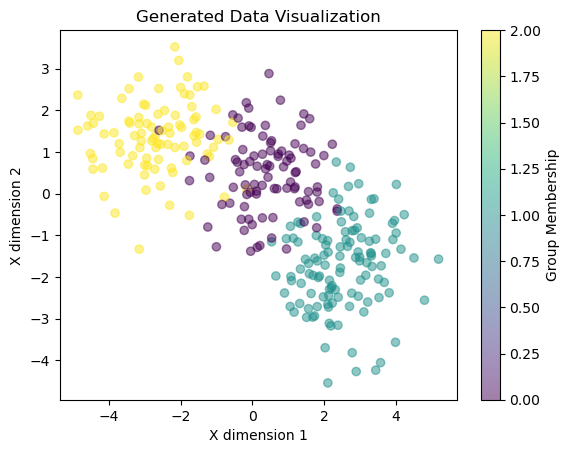

pred_mu_k [array([0.30061375, 0.52061514]), array([ 2.45850926, -1.66062612]), array([-2.5195887 ,  1.58424601])]


In [37]:
plt.scatter(X[:, 0], X[:, 1], c=pred_Z, cmap='viridis', alpha=0.5)
plt.title('Generated Data Visualization')
plt.xlabel('X dimension 1')
plt.ylabel('X dimension 2')
plt.colorbar(label='Group Membership')
plt.show()
print('pred_mu_k', pred_mu_k)

Implement the solution to the inference using variational inference by Pyro
